# **SEIS-8**


---
# Group Member


1.   NURUL MAISARAH BINTI HAZARASIM (A195575)
2.   NUR DINI IZZATY BINTI MOHD SHAFIDZAN (A196139)
3.   MUHAMMAD DANIAL HAZIM BIN MOH RAFAIN (A194155)
4.   MUHAMMAD ASHRIL BIN NAZARUDDIN  (A193421)




# **SCRAPE DATA**

In [ ]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import time

# Base URL for the Booking.com search results
base_url = "https://www.booking.com/searchresults.html"
params = {
    'aid': '304142',
    'label': 'gen173nr-1FCAQoggI49ANIM1gEaKEBiAEBmAExuAEXyAEM2AEB6AEB-AECiAIBqAIDuALt2OO8BsACAdICJDcxMGVkMDBmLWEyODgtNDdmZi1hNDIxLTU1M2I5YTEyMWM5MdgCBeACAQ',
    'checkin': '2025-02-03',
    'checkout': '2025-02-04',
    'dest_id': '-2403010',
    'dest_type': 'city',
    'group_adults': '2',
    'req_adults': '2',
    'no_rooms': '1',
    'group_children': '0',
    'req_children': '0',
    'offset': 0  # Used for pagination
}

# Headers to mimic a browser request
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}

# Number of pages to scrape
total_pages = 6



# Loop through each page
for page in range(total_pages):
    params['offset'] = page * 25
    print(f"Scraping page {page + 1} with offset {params['offset']}...")

    # Request the page content
    response = requests.get(base_url, params=params, headers=headers)
    if response.status_code != 200:
        print(f"Failed to fetch page {page + 1} (Status code: {response.status_code})")
        continue

    # Parse the page content
    soup = BeautifulSoup(response.text, 'html.parser')

    # Initialize an empty list to store data
    data_list = []

    # Exchange rate for price conversion
    exchange_rate = 4.58

    # Extract relevant data
    titles = soup.find_all("div", {"class": "f6431b446c a15b38c233"})
    rates = soup.find_all("div", {"class": "a3b8729ab1 e6208ee469 cb2cbb3ccb"})
    rating_scores = soup.find_all("div", {"class": "a3b8729ab1 d86cee9b25"})
    types = soup.find_all("h4", {"class": "abf093bdfe e8f7c070a7"})
    locations_raw = soup.find_all("a", {"class": "a83ed08757 f88a5204c2 a1ae279108 b98133fb50"})
    num_reviews = soup.find_all("div", {"class": "abf093bdfe f45d8e4c32 d935416c47"})
    distance = soup.find_all("span", {"data-testid": "distance"})
    prices = soup.find_all("span", {"class": "f6431b446c fbfd7c1165 e84eb96b1f"})

    # Loop through all extracted elements and consolidate data
    for i in range(len(titles)):
        title = titles[i].text.strip() if i < len(titles) else "N/A"
        rate = rates[i].text.strip() if i < len(rates) else "N/A"
        rating_score = rating_scores[i].text.strip() if i < len(rating_scores) else "NaN"
        type_ = types[i].text.strip() if i < len(types) else "N/A"
        location = locations_raw[i].text.strip() if i < len(locations_raw) else "N/A"
        num_review = num_reviews[i].text.strip() if i < len(num_reviews) else "NaN"
        distances = distance[i].text.strip() if i < len(distance) else "N/A"
        price = prices[i].text.strip() if i < len(prices) else "NaN"


        # Append data to the list
        data_list.append({
            "Title": title,
            "Price (RM)": price,
            "Room Type": type_,
            "Location": location,
            "Distances": distances,
            "Review Category": rate,
            "Rating Score": rating_score,
            "Number of Reviews": num_review


        })

    # Pause between requests to avoid overwhelming the server
    time.sleep(2)

# Convert list to a DataFrame
data_df = pd.DataFrame(data_list)

# Save the DataFrame to a CSV file
csv_file_name = "bookingKualaLumpur.csv"
if not data_df.empty:
    data_df.to_csv(csv_file_name, index=False)
    print(f"Data successfully saved to {csv_file_name}")
else:
    print("No data scraped. CSV file not created.")

# Display a preview of the DataFrame
print(data_df.head())


Scraping page 1 with offset 0...
Scraping page 2 with offset 25...
Scraping page 3 with offset 50...
Scraping page 4 with offset 75...
Scraping page 5 with offset 100...
Scraping page 6 with offset 125...
Data successfully saved to bookingKualaLumpur.csv
                                Title Price (RM)  \
0      Platinum KLCC By Luxury Suites      US$61   
1                        The Bed KLCC      US$40   
2  Santa Grand Signature Kuala Lumpur      US$58   
3    The Axon Residence Bukit Bintang      US$34   
4            KlCC residences at Eaton      US$86   

                              Room Type  \
0                 One-Bedroom Apartment   
1  Private Queen Room (Shared Bathroom)   
2               Bong Soo Superior Queen   
3                   Superior Queen Room   
4                 One-Bedroom Apartment   

                                            Location              Distances  \
0  Kuala Lumpur City-Centre, Kuala LumpurShow on map  0.4 miles from centre   
1  Kuala Lumpur

# **DATA CLEAN**

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re
import time

data_df = pd.read_csv("/content/drive/MyDrive/DATA PROJECT/bookingKualaLumpur.csv")


# Exchange rate for price conversion
exchange_rate = 4.58

# Initialize an empty list to store data
data_list = []

# Function to convert distances from miles or feet to kilometers
def convert_distance_to_km(distance_str):
    try:
        if "miles" in distance_str.lower():
            # Convert miles to kilometers
            miles = float(''.join(filter(lambda x: x.isdigit() or x == '.', distance_str.split(' ')[0])))
            km = round(miles * 1.60934, 2)
        elif "feet" in distance_str.lower():
            # Convert feet to kilometers
            feet = float(''.join(filter(lambda x: x.isdigit() or x == '.', distance_str.split(' ')[0])))
            km = round(feet * 0.0003048, 2)
        else:
            return "N/A"
        return f"{km} km from downtown"
    except:
        return "N/A"

# Function to clean the "Number of Reviews" field
def clean_reviews(review_text):
    if "external" in review_text.lower():
        review_text = review_text.lower().replace("external", "").strip()
    return review_text if review_text else "No review"


    # Function to clean the "Review Category" field
def clean_review_category(review_text):
    if review_text.isdigit() or review_text.lower() == "n/a":
        return "Not Reviewed"
    return "".join(filter(lambda char: not char.isdigit(), review_text)).strip()



# Function to clean 'Rating Score'
def clean_rating_score(score):
    try:
        # Extract the first valid decimal number (e.g., "9.6")
        match = re.search(r'\d+(\.\d+)?', score)  # Match digits with optional decimals
        if match:
            return round(float(match.group()), 1)  # Convert the matched number to float and round to 2 decimal places
        return None  # Return None if no valid number is found
    except:
        return None  # Return None if any error occurs





    # Parse the page content
    soup = BeautifulSoup(response.text, 'html.parser')


    # Loop through all extracted elements and consolidate data
    for i in range(len(titles)):
        title = titles[i].text.strip() if i < len(titles) else "N/A"

        raw_review_category = review_categories[i].text.strip() if i < len(review_categories) else "N/A"
        clean_review_cat = clean_review_category(raw_review_category)

        rating_score = rating_scores[i].text.strip() if i < len(rating_scores) else "NaN"
        type_ = types[i].text.strip() if i < len(types) else "N/A"

        raw_location = locations_raw[i].text.strip() if i < len(locations_raw) else "N/A"
        clean_location_text = clean_location(raw_location)

        raw_review = num_reviews[i].text.strip() if i < len(num_reviews) else "No review"
        clean_review = clean_reviews(raw_review)

        distance_km = convert_distance_to_km(distance[i].text.strip()) if i < len(distance) else "N/A"

        price = prices[i].text.strip() if i < len(prices) else "NaN"


        # Append data to the list
        data_list.append({
            "Title": title,
            "Price (RM)": price,
            "Room Type": type_,
            "Location": clean_location_text,
            "Distances": distance_km,
            "Rating Score": rating_score,
            "Review Category": clean_review_cat,
            "Number of Reviews": clean_review})

    # Pause between requests to avoid overwhelming the server
    time.sleep(2)

   # Convert list to a DataFrame
    data_df = pd.DataFrame(data_list)



# Convert titles to title case for consistency
data_df['Title'] = data_df['Title'].str.title()

# Data Cleaning: Extract valid numeric ratings and round to 2 decimal places
data_df['Rating Score'] = data_df['Rating Score'].apply(clean_rating_score)

# Replace NaN values with the average of valid scores, rounded to 2 decimal places
average_rating = round(data_df['Rating Score'].dropna().mean(), 1)  # Calculate the mean of non-NaN values
data_df['Rating Score'] = data_df['Rating Score'].fillna(average_rating)  # Replace NaN with the mean

data_df['Review Category'] = data_df['Review Category'].str.replace(r'\s*\d+(\.\d+)?$', '', regex=True).str.strip()

data_df['Location'] = data_df['Location'].str.replace('Show on map', '').str.strip()

data_df['Number of Reviews']=data_df['Number of Reviews'].str.replace('external', '').str.strip()
data_df['Number of Reviews'] = data_df['Number of Reviews'].str.replace(r'[^0-9]', '', regex=True).astype(int)

data_df['Distances'] = data_df['Distances'].str.replace('from centre', '').str.strip()
# Data Cleaning: Convert 'Price (USD)' to MYR, remove unwanted text, and round to 2 decimal places
data_df['Price (MYR)'] = (
    data_df['Price (RM)']
    .astype(str)  # Ensure column is treated as string
    .str.replace('US', '')  # Remove "US"
    .str.replace('€', '')  # Remove dollar sign
    .str.replace(',', '')  # Remove commas
    .str.replace('\xa0', '')  # Remove non-breaking spaces
    .astype(float)  # Convert cleaned string to float
    * exchange_rate  # Convert to MYR
)
data_df['Price (MYR)'] = data_df['Price (MYR)'].round(3)  # Round to 2 decimal places

# Keep only 'Title' and 'Price (MYR)' columns
data_df = data_df[['Title', 'Price (MYR)', 'Room Type','Location','Distances','Review Category','Rating Score','Number of Reviews']]

# Save the DataFrame to a CSV file
csv_file_name = "bookingKualaLumpur_Cleaned.csv"
if not data_df.empty:
    data_df.to_csv(csv_file_name, index=False)
    print(f"Data successfully saved to {csv_file_name}")
else:
    print("No data scraped. CSV file not created.")

# Display a preview of the DataFrame
print(data_df.head())


Data successfully saved to bookingKualaLumpur_Cleaned.csv
                                               Title  Price (MYR)  \
0                     Platinum Klcc By Luxury Suites       288.54   
1                 Santa Grand Signature Kuala Lumpur       265.64   
2                   The Axon Residence Bukit Bintang       187.78   
3                           Jw Marriott Kuala Lumpur       540.44   
4  Tropicana Residence Kuala Lumpur By Collective...       343.50   

                 Room Type                                Location Distances  \
0    One-Bedroom Apartment  Kuala Lumpur City-Centre, Kuala Lumpur    0.6 km   
1  Bong Soo Standard Queen  Kuala Lumpur City-Centre, Kuala Lumpur    0.8 km   
2      Superior Queen Room             Bukit Bintang, Kuala Lumpur    1.2 km   
3       Superior Twin Room             Bukit Bintang, Kuala Lumpur    0.9 km   
4    【City View】King Suite  Kuala Lumpur City-Centre, Kuala Lumpur    0.5 km   

  Review Category  Rating Score  Number of Rev

# **DATA VISUALIZATION**

Attribute Price before and after cleaning

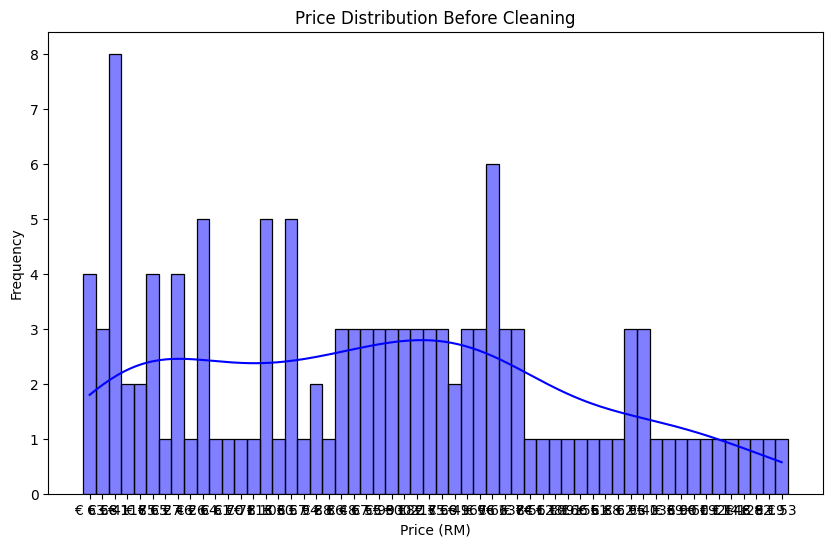

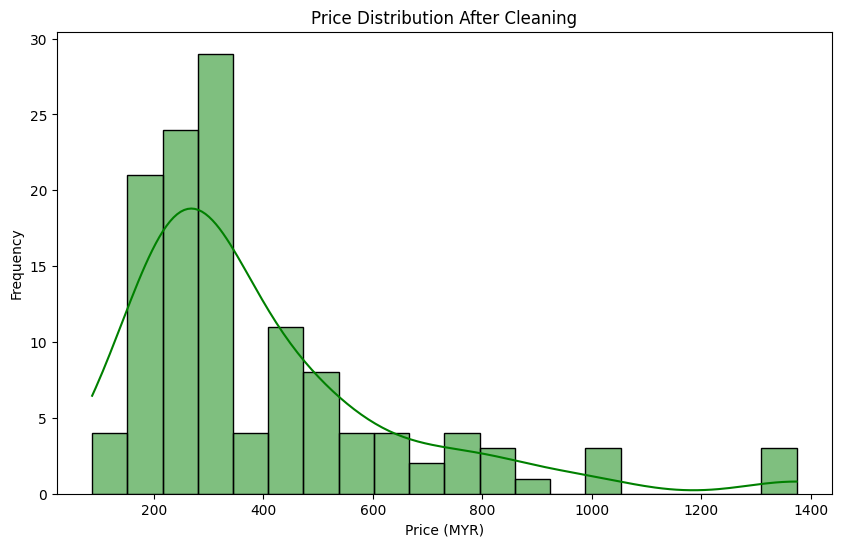

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import pandas as pd

data_df = pd.read_csv("/content/drive/MyDrive/DATA PROJECT/bookingKualaLumpur.csv")
# Plot price distribution before cleaning
plt.figure(figsize=(10, 6))
sns.histplot(data_df['Price (RM)'], kde=True, bins=20, color='blue')
plt.title('Price Distribution Before Cleaning')
plt.xlabel('Price (RM)')
plt.ylabel('Frequency')
plt.show()


data_df = pd.read_csv("/content/drive/MyDrive/DATA PROJECT/bookingKualaLumpur_Cleaned.csv")
# Plot price distribution after cleaning
plt.figure(figsize=(10, 6))
sns.histplot(data_df['Price (MYR)'], kde=True, bins=20, color='green')
plt.title('Price Distribution After Cleaning')
plt.xlabel('Price (MYR)')
plt.ylabel('Frequency')
plt.show()

Attribute Rating Scores before and after cleaning

<ipython-input-15-f21f8f819016>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=data_df['Rating Score'], palette='coolwarm')


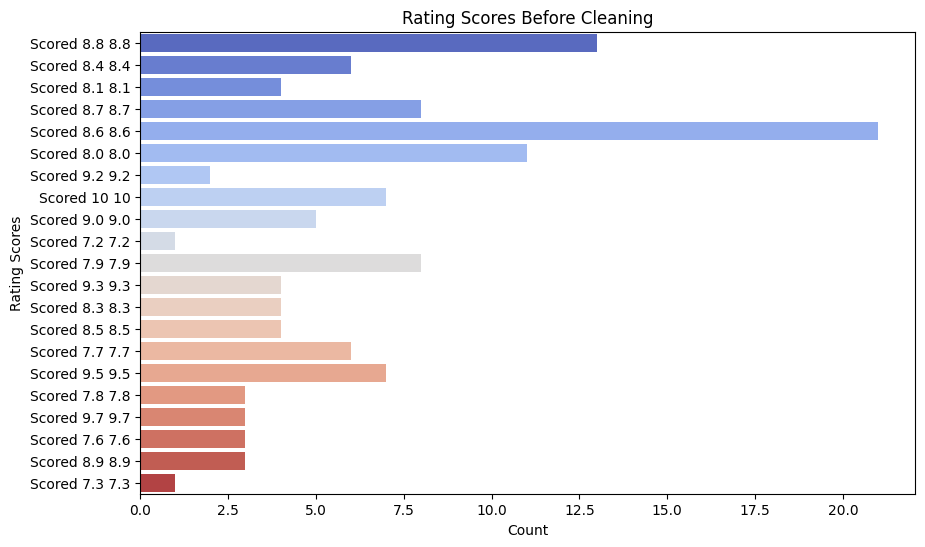

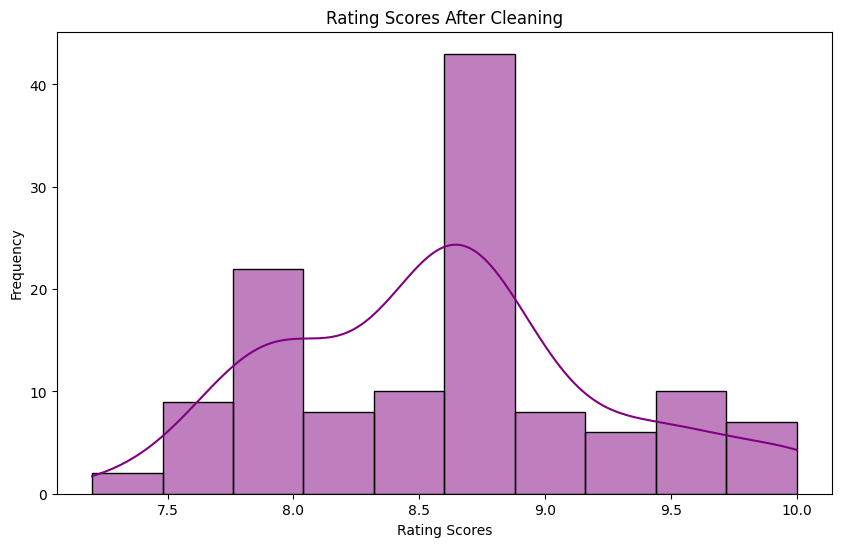

In [15]:
data_df = pd.read_csv("/content/drive/MyDrive/DATA PROJECT/bookingKualaLumpur.csv")

plt.figure(figsize=(10, 6))
sns.countplot(y=data_df['Rating Score'], palette='coolwarm')
plt.title('Rating Scores Before Cleaning')
plt.xlabel('Count')
plt.ylabel('Rating Scores')
plt.show()


data_df = pd.read_csv("/content/drive/MyDrive/DATA PROJECT/bookingKualaLumpur_Cleaned.csv")

# Plot Rating Scores after cleaning
plt.figure(figsize=(10, 6))
sns.histplot(data_df['Rating Score'], kde=True, bins=10, color='purple')
plt.title('Rating Scores After Cleaning')
plt.xlabel('Rating Scores')
plt.ylabel('Frequency')
plt.show()

Attribute Review Category before and after cleaning

<ipython-input-18-04ac50ca4b69>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=data_df['Review Category'], palette='coolwarm')


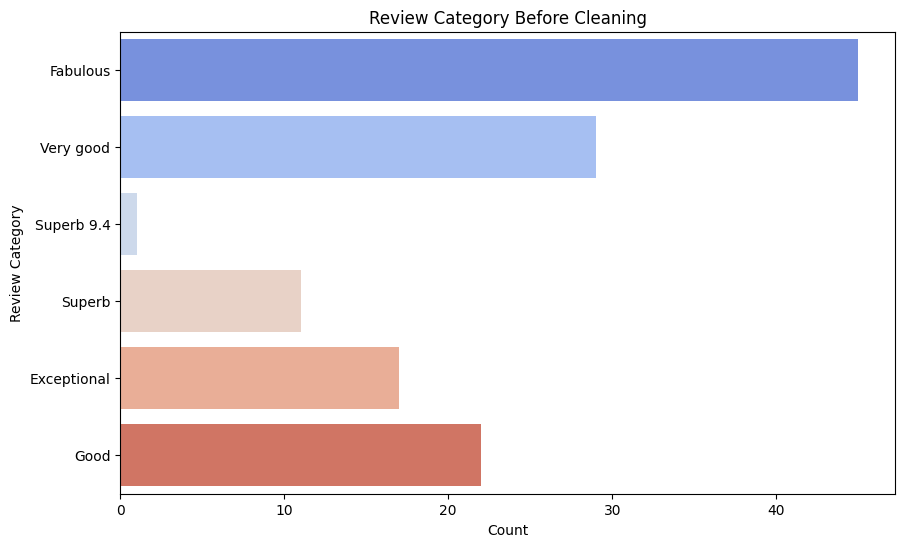

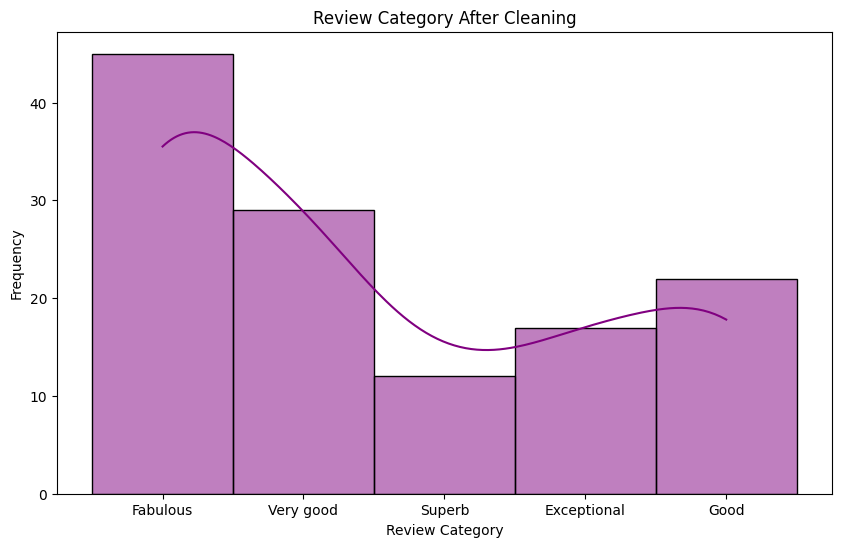

In [18]:
data_df = pd.read_csv("/content/drive/MyDrive/DATA PROJECT/bookingKualaLumpur.csv")

plt.figure(figsize=(10, 6))
sns.countplot(y=data_df['Review Category'], palette='coolwarm')
plt.title('Review Category Before Cleaning')
plt.xlabel('Count')
plt.ylabel('Review Category')
plt.show()


data_df = pd.read_csv("/content/drive/MyDrive/DATA PROJECT/bookingKualaLumpur_Cleaned.csv")


# Plot Rating Scores after cleaning
plt.figure(figsize=(10, 6))
sns.histplot(data_df['Review Category'], kde=True, bins=10, color='purple')
plt.title('Review Category After Cleaning')
plt.xlabel('Review Category')
plt.ylabel('Frequency')
plt.show()